In [1]:
# Cell 1: Imports and Setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from tqdm import tqdm
import logging

# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

In [2]:
# Cell 2: Data Loading and Preprocessing
class ClockDrawingDataset(Dataset):
    def __init__(self, folder_path, num_files=100):
        self.data = []
        files = [f for f in os.listdir(folder_path) if f.endswith('.svc')][:num_files]
        
        if not files:
            raise ValueError(f"No .svc files found in {folder_path}")
        
        for file in tqdm(files, desc="Loading files"):
            try:
                # Read the file, skipping the first row
                with open(os.path.join(folder_path, file), 'r') as f:
                    next(f)  # Skip the first line
                    lines = f.readlines()
                
                # Parse the lines
                sequence = []
                for line in lines:
                    values = line.strip().split()
                    if len(values) >= 4:
                        x, y, _, pen_status = map(float, values[:4])
                        sequence.append([x, y, pen_status])
                
                if sequence:
                    self.data.append(np.array(sequence))
                else:
                    logging.warning(f"File {file} contains no valid data. Skipping.")
            
            except Exception as e:
                logging.error(f"Error processing file {file}: {str(e)}")
        
        if not self.data:
            raise ValueError("No valid data found in the provided files.")
        
        logging.info(f"Successfully loaded {len(self.data)} files.")
        
        # Pad sequences to the same length
        max_length = max(len(seq) for seq in self.data)
        self.data = [np.pad(seq, ((0, max_length - len(seq)), (0, 0)), 'constant') for seq in self.data]
        
        # Normalize x and y coordinates
        scaler = MinMaxScaler()
        self.data = [np.column_stack((scaler.fit_transform(seq[:, :2]), seq[:, 2])) for seq in self.data]
        
        self.data = torch.FloatTensor(self.data)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# Cell 3 (modified)
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        h = h.squeeze(0)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, seq_len):
        super(Decoder, self).__init__()
        self.fc = nn.Linear(latent_dim, hidden_dim)
        self.lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, output_dim)
        self.seq_len = seq_len

    def forward(self, z):
        h = self.fc(z).unsqueeze(1).repeat(1, self.seq_len, 1)
        output, _ = self.lstm(h)
        return self.output_layer(output)

class Discriminator(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(Discriminator, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        _, (h, _) = self.lstm(x)
        return self.fc(h.squeeze(0))

class BetaVAEGAN(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim, seq_len, beta=1.0):
        super(BetaVAEGAN, self).__init__()
        self.encoder = Encoder(input_dim, hidden_dim, latent_dim)
        self.decoder = Decoder(latent_dim, hidden_dim, input_dim, seq_len)
        self.discriminator = Discriminator(input_dim, hidden_dim)
        self.beta = beta

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


In [4]:
# Cell 4: Training Functions
def vae_loss(recon_x, x, mu, logvar, beta):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD

def train_vaegan(model, train_loader, num_epochs, lr, device):
    optimizer_vae = optim.Adam(list(model.encoder.parameters()) + list(model.decoder.parameters()), lr=lr)
    optimizer_disc = optim.Adam(model.discriminator.parameters(), lr=lr)
    
    for epoch in range(num_epochs):
        model.train()
        epoch_vae_loss = 0
        epoch_gen_loss = 0
        epoch_disc_loss = 0
        
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
        for batch in progress_bar:
            batch = batch.to(device)
            
            # Train VAE
            optimizer_vae.zero_grad()
            recon_batch, mu, logvar = model(batch)
            vae_loss_val = vae_loss(recon_batch, batch, mu, logvar, model.beta)
            disc_fake = model.discriminator(recon_batch)
            gen_loss = -torch.mean(disc_fake)
            total_loss = vae_loss_val + gen_loss
            total_loss.backward()
            optimizer_vae.step()
            
            # Train Discriminator
            optimizer_disc.zero_grad()
            disc_real = model.discriminator(batch)
            disc_fake = model.discriminator(recon_batch.detach())
            disc_loss = -torch.mean(disc_real) + torch.mean(disc_fake)
            disc_loss.backward()
            optimizer_disc.step()
            
            # Clip discriminator weights
            for p in model.discriminator.parameters():
                p.data.clamp_(-0.01, 0.01)
            
            epoch_vae_loss += vae_loss_val.item()
            epoch_gen_loss += gen_loss.item()
            epoch_disc_loss += disc_loss.item()
            
            progress_bar.set_postfix({
                'VAE Loss': f"{vae_loss_val.item():.4f}",
                'Gen Loss': f"{gen_loss.item():.4f}",
                'Disc Loss': f"{disc_loss.item():.4f}"
            })
        
        avg_vae_loss = epoch_vae_loss / len(train_loader)
        avg_gen_loss = epoch_gen_loss / len(train_loader)
        avg_disc_loss = epoch_disc_loss / len(train_loader)
        
        logging.info(f"Epoch [{epoch+1}/{num_epochs}], "
                     f"Avg VAE Loss: {avg_vae_loss:.4f}, "
                     f"Avg Gen Loss: {avg_gen_loss:.4f}, "
                     f"Avg Disc Loss: {avg_disc_loss:.4f}")

In [5]:
# Cell 5: Data Visualization Functions
def plot_original_data(dataset, num_samples=5, marker_size=2):
    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 4*num_samples))
    for i in range(num_samples):
        sample = dataset[i].numpy()
        axes[i].plot(sample[:, 0][sample[:, 2] == 1], sample[:, 1][sample[:, 2] == 1], 'b.', markersize=marker_size, label='On paper')
        axes[i].plot(sample[:, 0][sample[:, 2] == 0], sample[:, 1][sample[:, 2] == 0], 'r.', markersize=marker_size, label='In air')
        axes[i].set_title(f'Sample {i+1}')
        axes[i].legend()
    plt.tight_layout()
    plt.show()

def plot_augmented_data(model, num_samples=5, marker_size=2):
    model.eval()
    with torch.no_grad():
        z = torch.randn(num_samples, model.encoder.fc_mu.out_features)
        generated = model.decoder(z).cpu().numpy()

    fig, axes = plt.subplots(num_samples, 1, figsize=(10, 4*num_samples))
    for i in range(num_samples):
        sample = generated[i]
        pen_status = (sample[:, 2] > 0.5).astype(int)  # Binary classification
        axes[i].plot(sample[:, 0][pen_status == 1], sample[:, 1][pen_status == 1], 'b.', markersize=marker_size, label='On paper')
        axes[i].plot(sample[:, 0][pen_status == 0], sample[:, 1][pen_status == 0], 'r.', markersize=marker_size, label='In air')
        axes[i].set_title(f'Generated Sample {i+1}')
        axes[i].legend()
    plt.tight_layout()
    plt.show()



2024-09-10 18:35:02,169 - INFO - Loading and preprocessing data...
Loading files: 100%|██████████| 30/30 [00:01<00:00, 25.64it/s]
2024-09-10 18:35:03,356 - INFO - Successfully loaded 30 files.
C:\Users\annek\AppData\Local\Temp\ipykernel_9500\2897201228.py:46: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:281.)
  self.data = torch.FloatTensor(self.data)
2024-09-10 18:35:04,820 - INFO - Plotting original data samples...


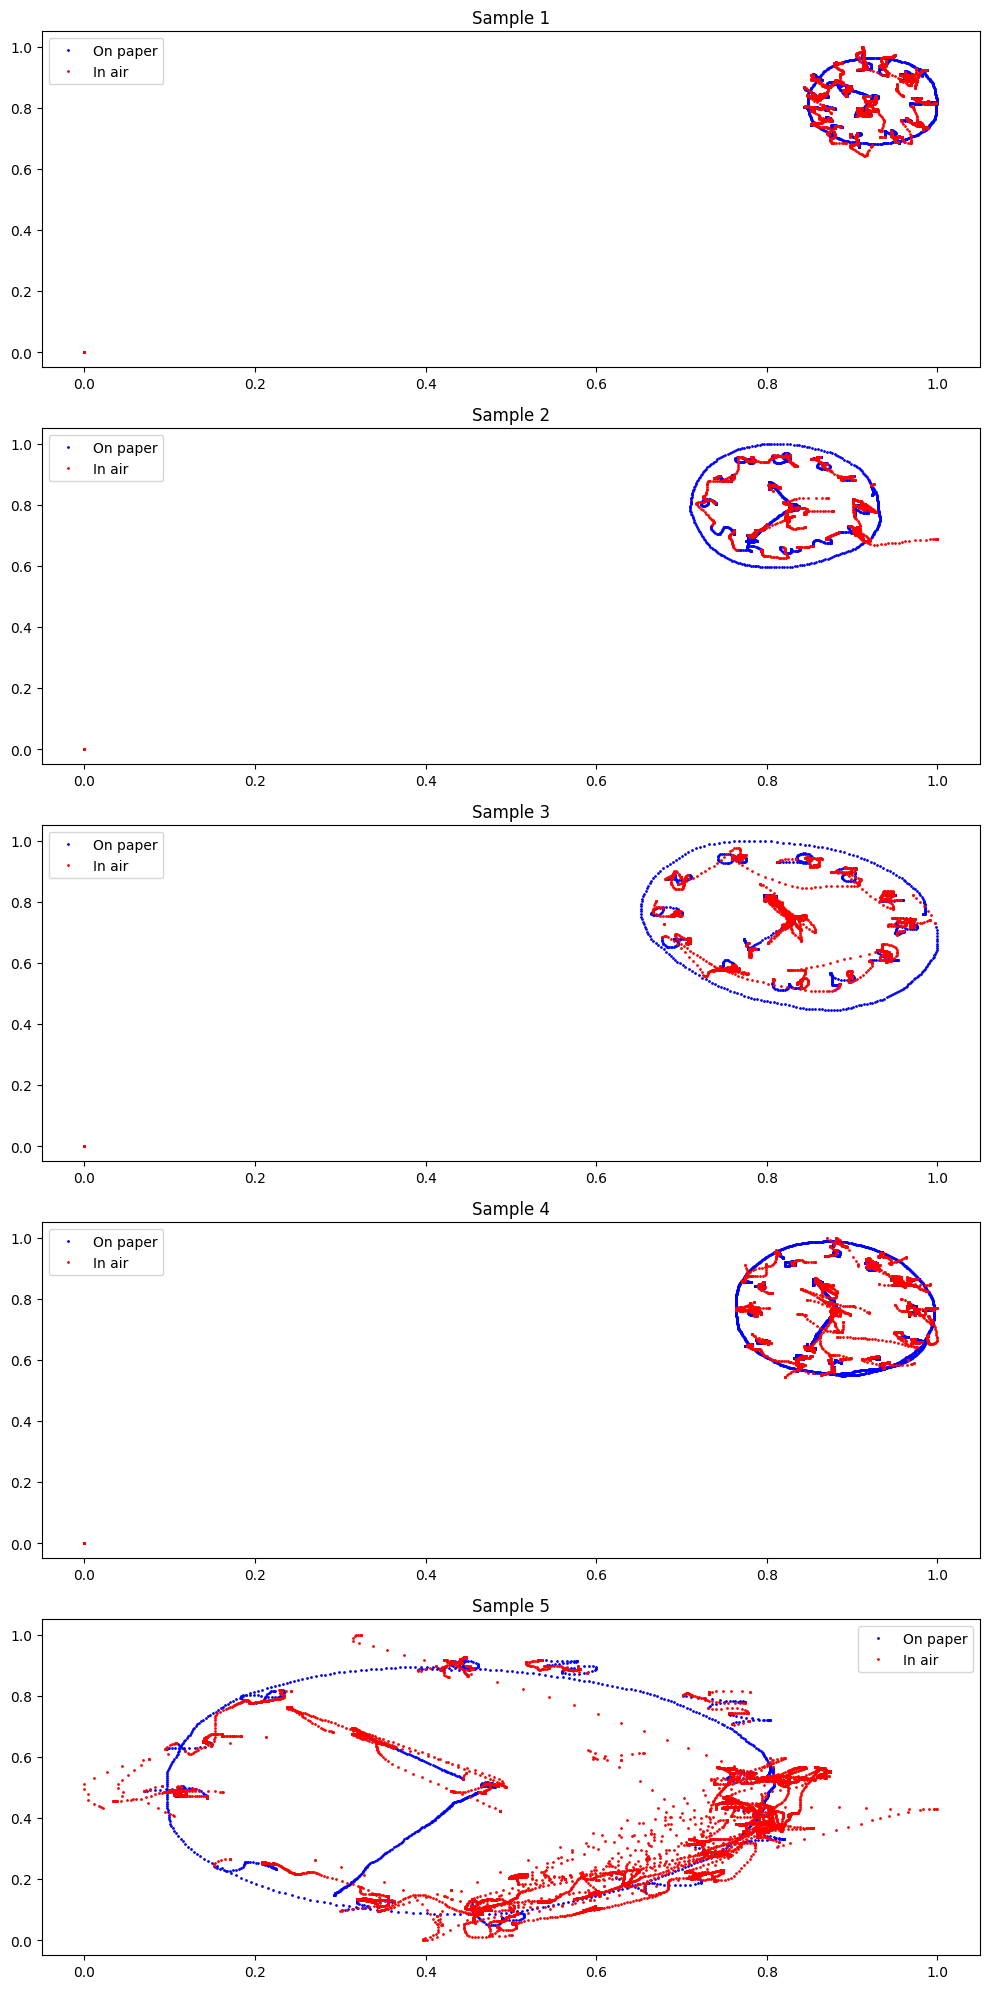

2024-09-10 18:35:06,785 - INFO - Initializing model...
2024-09-10 18:35:06,809 - INFO - Training model on cpu...
Epoch 1/10: 100%|██████████| 2/2 [00:21<00:00, 10.58s/it, VAE Loss=112649.7969, Gen Loss=-0.0100, Disc Loss=0.0000] 
2024-09-10 18:35:30,755 - INFO - Epoch [1/10], Avg VAE Loss: 119698.2852, Avg Gen Loss: -0.0357, Avg Disc Loss: -0.0004
Epoch 2/10: 100%|██████████| 2/2 [00:20<00:00, 10.48s/it, VAE Loss=102289.4219, Gen Loss=-0.0100, Disc Loss=0.0000] 
2024-09-10 18:35:51,714 - INFO - Epoch [2/10], Avg VAE Loss: 109648.4453, Avg Gen Loss: -0.0100, Avg Disc Loss: -0.0000
Epoch 3/10: 100%|██████████| 2/2 [00:20<00:00, 10.48s/it, VAE Loss=91222.2422, Gen Loss=-0.0100, Disc Loss=0.0000]  
2024-09-10 18:36:12,673 - INFO - Epoch [3/10], Avg VAE Loss: 103678.4883, Avg Gen Loss: -0.0100, Avg Disc Loss: -0.0000
Epoch 4/10: 100%|██████████| 2/2 [00:19<00:00,  9.77s/it, VAE Loss=94972.7188, Gen Loss=-0.0100, Disc Loss=-0.0001] 
2024-09-10 18:36:32,238 - INFO - Epoch [4/10], Avg VAE Loss

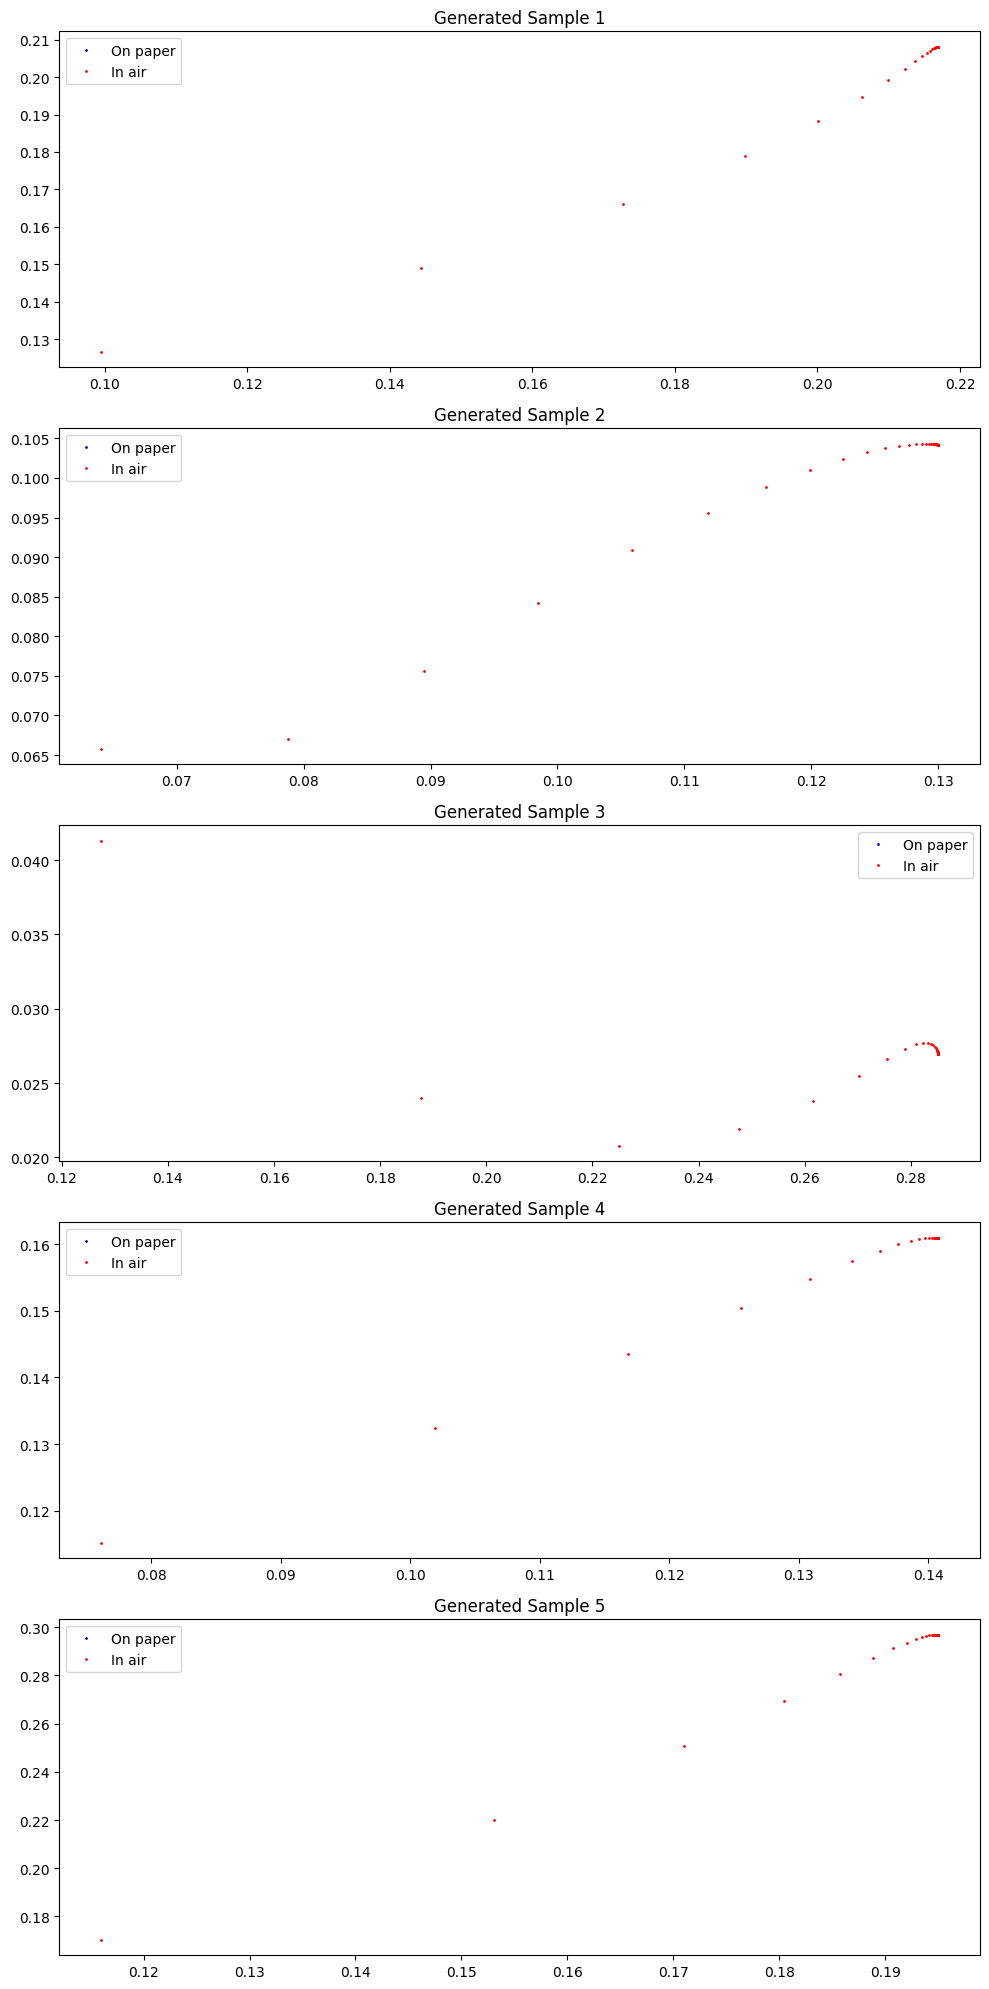

2024-09-10 18:38:30,705 - INFO - Process completed successfully.


In [6]:
# Cell 6: Main Execution
def main():
    # Hyperparameters
    input_dim = 3
    hidden_dim = 64
    latent_dim = 256
    batch_size = 16
    num_epochs = 10
    lr = 0.001
    beta = 0.0001
    num_files = 30  # Number of .svc files to use
    
    logging.info("Loading and preprocessing data...")
    dataset = ClockDrawingDataset('Task6', num_files=num_files)
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    logging.info("Plotting original data samples...")
    plot_original_data(dataset)
    
    logging.info("Initializing model...")
    seq_len = dataset[0].shape[0]
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    model = BetaVAEGAN(input_dim, hidden_dim, latent_dim, seq_len, beta).to(device)
    
    logging.info(f"Training model on {device}...")
    train_vaegan(model, train_loader, num_epochs, lr, device)
    
    logging.info("Generating and plotting augmented data...")
    plot_augmented_data(model)
    
    logging.info("Process completed successfully.")

if __name__ == "__main__":
    main()

TypeError: 'function' object is not iterable